In [112]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

import astropy.utils.exceptions
from astropy.io import fits
from matplotlib.patches import Rectangle
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, IRAFStarFinder
from photutils import aperture_photometry, CircularAperture
from astropy import modeling

In [113]:
#Extinction Coefficents from HW5
B_exc=0.2129847272913416;V_exc=0.1826482582700005;R_exc=0.19804251689928645

#Zero points and first color terms
B_ZP =  -1.369113638279561 
B_CT =  1.9285376283917643

V_ZP =  -0.4533700139358969 
V_CT =  0.6248957544930135

In [114]:
#Method to calculate magntiudes from a reduced image given a list of positions

def aperture_phot2mags(data,positions):
    
    #Draw Apertures of 5 pixels
    apertures = CircularAperture(positions, r=5) 

    #Do photometry in those apertures
    phot_table = aperture_photometry(data, apertures) 

    #calculate photmetry-background level in aperture
    sub_phot=phot_table['aperture_sum']-25*np.median(data)

    #calculate magnitudes with arbitrary zero-point
    m=-2.5*np.log10(sub_phot/hdul[0].header['EXPTIME'])+25
    return(m)

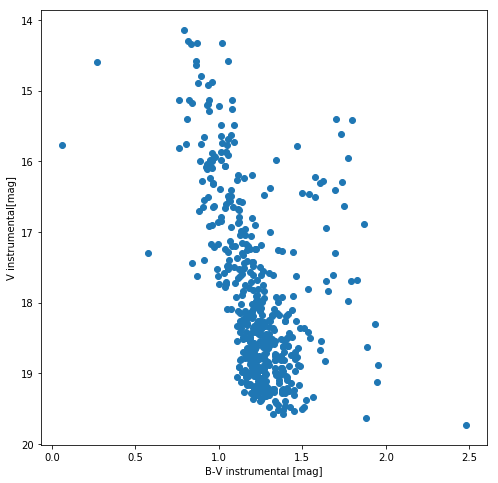

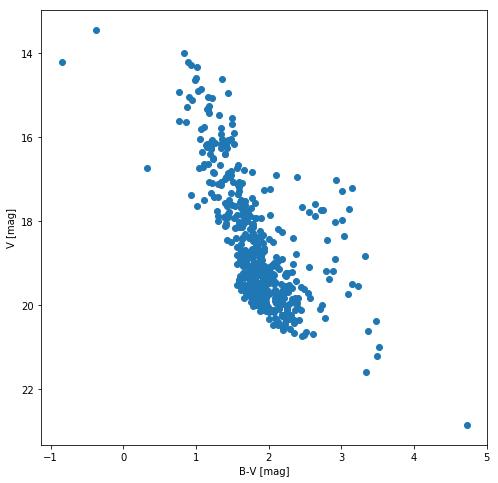

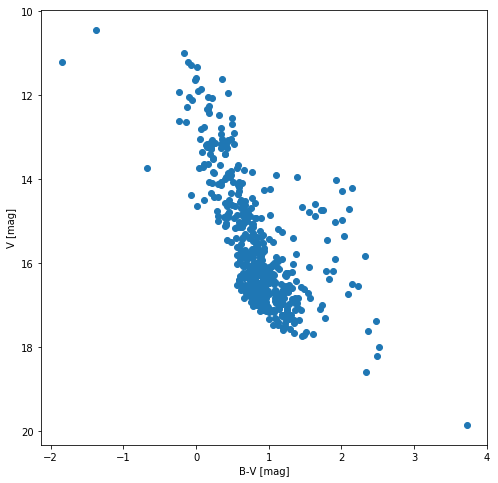

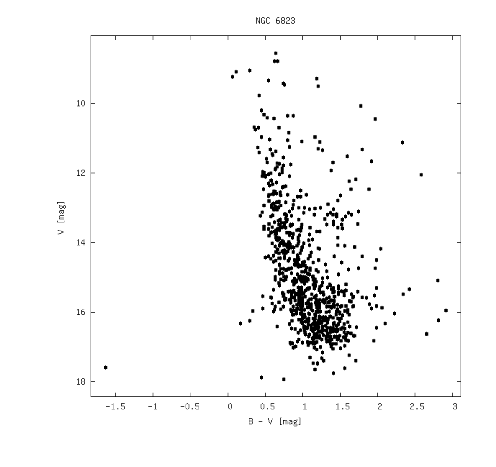

In [111]:
#NGC6823 Images, 159-V 160-B airmass=1.10
V_data=fits.open('Imaging_zf_bf_mf/a159.fits.zf.bf.mf')[0].data
B_data=fits.open('Imaging_zf_bf_mf/a160.fits.zf.bf.mf')[0].data


#Find stars and positions

#create DAOStarFinder instance, low threshold value
daofind = DAOStarFinder(fwhm=5.0, threshold=0.50*np.std(V_data),peakmax=60000)
#find sources using starfinder
sources = daofind(V_data - np.median(V_data))
#write postions into readable format for photometry method
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
#find magnitudes    
V_mags=aperture_phot2mags(V_data,positions)
B_mags=aperture_phot2mags(B_data,positions)

#correct to zero extinction
V_0=V_mags-V_exc*1.1
B_0=B_mags-B_exc*1.1

#correct to standard system
V_crc=V_0+V_ZP+V_CT*(B_0-V_0)
B_crc=B_0+B_ZP+B_CT*(B_0-V_0)

#De-reddening (current guess values)
A_V=2; A_B=3

V_drd=V_crc-A_V
B_drd=B_crc-A_B

#plot instrumentals
plt.figure(figsize=(8,8))
plt.scatter(B_mags-V_mags,B_mags)
plt.xlabel('B-V instrumental [mag]')
plt.ylabel('V instrumental[mag]')
plt.gca().invert_yaxis()
plt.show()

#plot corrected
plt.figure(figsize=(8,8))
plt.scatter(B_crc-V_crc,B_crc)
plt.xlabel('B-V [mag]')
plt.ylabel('V [mag]')
plt.gca().invert_yaxis()
plt.show()

#plot de-reddened
plt.figure(figsize=(8,8))
plt.scatter(B_drd-V_drd,B_drd)
plt.xlabel('B-V [mag]')
plt.ylabel('V [mag]')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8,8))
img=mpimg.imread('NGC6823.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


Comparison to Published data from https://webda.physics.muni.cz/cgi-bin/plot_cmd.cgi?ngc6823+NGC+6823

The shape of the CMDs match quite well. Additionally after de-reddeneding my data they occupy mostly the same same. Notably the published data consists of over 1000 stars whereas mine of only a few hundred.

[0. 0.]
[55.91986303 -5.99587512]
[262.70782989 172.10234427]
[375.02710938 181.72464371]
[455.00655094 132.74742764]


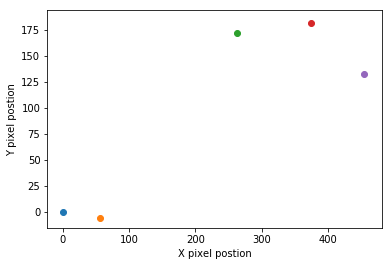

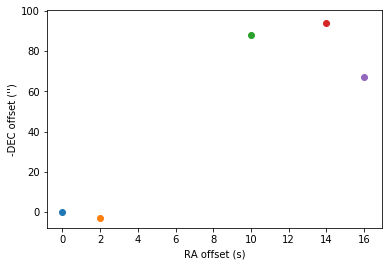

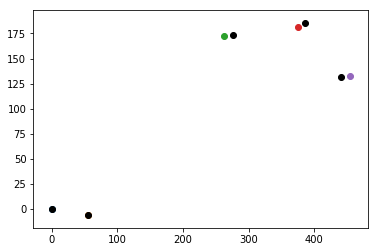

In [108]:
#calculate plate scale using known RA/DEC

#I'm going to use the known stars from the landolt standard field

hdul=fits.open('Imaging_zf_bf_mf/a083.fits.zf.bf.mf')
data=hdul[0].data[950:1450,950:1550]

daofind = DAOStarFinder(fwhm=6.0, threshold=12.*np.std(data))
sources = daofind(data - np.median(data))
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))


#sort by x values to align with values
positions=positions[positions[:,0].argsort()]

#subtract first index to get everything scaled to 0,0
positions=positions-positions[0]

#Landolt Standard RA/DEC values from http://james.as.arizona.edu/~psmith/charts/c109.html
#increase in RA with designation

#PG1633+099	16:35:24	+09:47:50
	
#PG1633+099A	16:35:26	+09:47:53	

#PG1633+099B	16:35:34	+09:46:22	

#PG1633+099C	16:35:38	+09:46:16	

#PG1633+099D	16:35:40	+09:46:43

#seperations scaled to first star, note +DEC is - valued to match x,y
#changes in ra *15 to get to arcsec
stars=[[0,0],[2,-3],[10,88],[14,94],[16,67]]


#plt_scale guess =2,1.95,1.93,1.98 pix/'' from y_diff rel to dec diff


#from wiro-rime 0.5224 arcsec/pixel
for i in positions:
    print(i)
    plt.scatter(i[0],i[1])
plt.xlabel('X pixel postion')
plt.ylabel('Y pixel postion')
plt.show()

for i in stars:
    plt.scatter(i[0],i[1])
plt.xlabel('RA offset (s)')
plt.ylabel('-DEC offset (\'\')')
plt.show()

plt_scale=1.97

for i in positions:
    plt.scatter(i[0],i[1])
for j in stars:
    plt.scatter(plt_scale*14.0*j[0],plt_scale*j[1],c='k')

plt.show()